In [116]:
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import numpy.linalg as la
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
import cvxopt
np.random.seed(0)
import seaborn as sns
import random as rd
import csv
import random
import math
import operator
import copy
import os,os.path

In [94]:
def trainsubset(data,drop_size):
    if isinstance(drop_size,float):
        drop_size=round(drop_size * len(data))
    indices = data.index.tolist()
    drop_indices = random.sample(population=indices,k=drop_size)
    train_subdata = data.drop(drop_indices)
    return train_subdata

In [95]:
data = pd.read_csv("E:\\SMAI_A2\\Q5\\Question-5\\train.csv")
data = data.drop(['Unnamed: 0'],axis=1)
random.seed(0)
data = trainsubset(data,drop_size=0.50)
print(data.shape)

(7831, 2)


In [96]:
corpus = np.array(data["text"])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
#features = vectorizer.get_feature_names() 
X = X.toarray()
#print(X)

In [78]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [79]:
reduced_X = pca.transform(X)

In [84]:
reduced_X.shape

(7831, 2)

In [85]:
labels = np.array(data["author"])

# One Vs. All For Multiclass

In [14]:
def findtrainsubset(X,Y,drop_size):
        Xsub=[]
        Ysub=[]
        indices=[]
        if isinstance(drop_size,float):
            drop_size=round(drop_size * len(X))
        for i in range(len(X)):
            indices.append(i)
        drop_indices = random.sample(population=indices,k=drop_size)
        for i in range(len(X)):
            if i not in drop_indices:
                Xsub.append(X[i,:])
                Ysub.append(Y[i])
        Xsub=np.array(Xsub)
        Ysub=np.array(Ysub)
        return Xsub,Ysub

In [15]:
def segregateclasses(data,labels):
    data_classes={}
    for i in range(labels.shape[0]):
        if labels[i] not in data_classes:
            data_classes[labels[i]]=[]
        temp=data[i,:]
        temp=list(temp)
        data_classes[labels[i]].append(temp)
    return data_classes

In [17]:
def combineoneall(data,i):
    l1=data[i].shape[0]
    l2=0
    idx=l1
    for j in data:
        if(i!=j):
            l2+=data[j].shape[0]
    sample_size=l1+l2
    feature_size=data[i].shape[1]
    data_pair=np.zeros((sample_size,feature_size))
    data_labels=np.zeros((sample_size,1))
    data_pair[:l1,:]=data[i]
    
    for j in data:
        if(j!=i):
            for k in range(data[j].shape[0]):
                data_pair[idx,:]=data[j][k]
                idx+=1
                
    data_labels[:l1]=-1
    data_labels[l1:]=1
    return data_pair,data_labels

 # Linear SVM Algorithm

In [146]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=20):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        losses = []
        
        for i in range(maxItr):
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,batch_size):
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

# Train Linear SVM

In [147]:
mysvm = SVM()

In [152]:
def trainSVMs(y):
    svm_classifiers = {}
    number_of_classes = len(np.unique(y))
    for i in range(len(data_classes)):
        xpair,ypair=combineoneall(data_classes,classes[i])
        w,bias,losses = mysvm.fit(xpair, ypair,learning_rate=0.00001,maxItr=200)
        svm_classifiers[i]=(w,bias)
        plt.plot(losses)
        plt.show()    
    return svm_classifiers

## For C=1.0

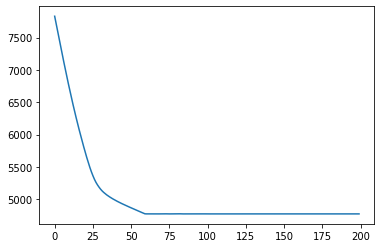

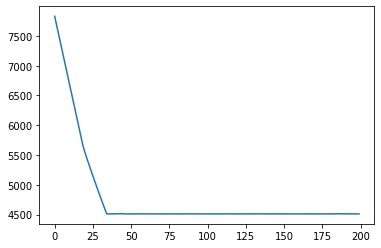

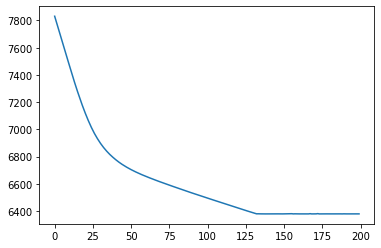

In [153]:
svm_classifiers = trainSVMs(labels)

## For C=0.001 

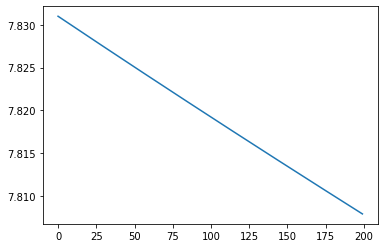

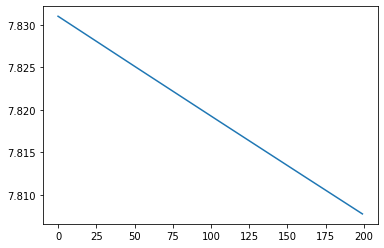

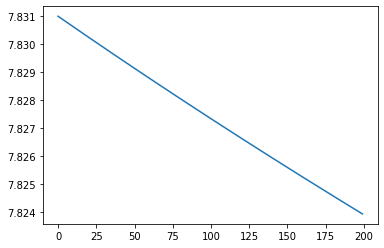

In [154]:
mysvm.C=0.001
svm_classifiers = trainSVMs(labels)

## For C=100

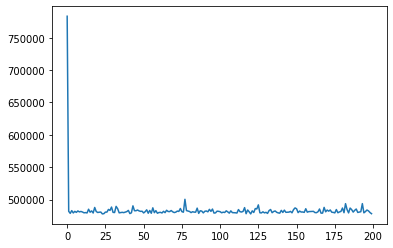

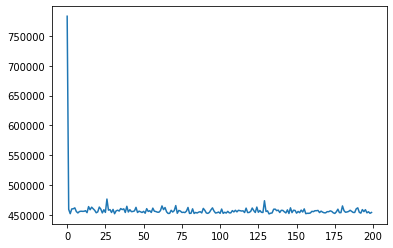

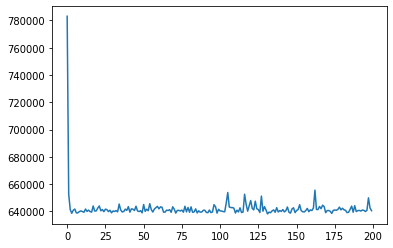

In [155]:
mysvm.C=100
svm_classifiers = trainSVMs(labels)

# Kernel SVMs

In [71]:
class Kernel(object):
    @staticmethod
    def linear():
        def f(x, y):
            return np.inner(x, y)
        return f

    @staticmethod
    def gaussian(sigma):
        def f(x, y):
            exponent = -np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2))
            return np.exp(exponent)
        return f

    @staticmethod
    def _polykernel(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

In [72]:
class SVMPredictor(object):
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels

    def predict(self, x):
        result = self._bias
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()

In [67]:
class SVMTrainer(object):
    def __init__(self, kernel, c):
        self._kernel = kernel
        self._c = c

    def train(self, X, y):
        lagrange_multipliers = self._compute_multipliers(X, y)
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _gram_matrix(self, X):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        # TODO(tulloch) - vectorize
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5
        support_vector_indices = \
            lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]
        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _compute_multipliers(self, X, y):
        n_samples, n_features = X.shape
        K = self._gram_matrix(X)
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)
        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
      
        return np.ravel(solution['x'])


In [87]:
mysvm = SVMTrainer(Kernel.linear(),0.05)
data_classes = segregateclasses(reduced_X,labels)
for i in data_classes.keys():
    data_classes[i]=np.array(data_classes[i])
classes = []
for i in data_classes:
    classes.append(i)

In [88]:
reduced_X.shape

(7831, 2)

In [70]:
xpair,ypair=combineoneall(data_classes,classes[0])
xsub,ysub=findtrainsubset(xpair,ypair,0.90)
predictor = mysvm.train(xsub, ysub)

     pcost       dcost       gap    pres   dres
 0: -6.6821e+02 -2.0092e+02  1e+04  6e+01  1e-13
 1: -5.8919e+01 -1.9666e+02  5e+02  1e+00  1e-13
 2: -4.3840e+01 -1.1615e+02  8e+01  7e-02  1e-14
 3: -4.5745e+01 -6.9668e+01  3e+01  2e-02  7e-15
 4: -4.6190e+01 -5.9492e+01  1e+01  1e-02  9e-15
 5: -4.6473e+01 -5.0725e+01  4e+00  9e-15  1e-14
 6: -4.7083e+01 -4.7204e+01  1e-01  1e-14  1e-14
 7: -4.7100e+01 -4.7101e+01  1e-03  1e-14  1e-14
 8: -4.7100e+01 -4.7100e+01  1e-05  5e-15  8e-15
Optimal solution found.


In [90]:
def trainSVMs(y):
    svm_classifiers = {}
    number_of_classes = len(np.unique(y))
    for i in range(len(data_classes)):
        xpair,ypair=combineoneall(data_classes,classes[i])
        svm_classifiers[i] = mysvm.train(xpair, ypair)
            
    return svm_classifiers

In [91]:
predictor = trainSVMs(labels)

     pcost       dcost       gap    pres   dres
 0: -3.3652e+03 -9.9953e+02  7e+04  6e+01  4e-13
 1: -3.0331e+02 -9.7837e+02  2e+03  2e+00  4e-13
 2: -2.1930e+02 -6.1698e+02  5e+02  8e-02  6e-14
 3: -2.3071e+02 -3.4773e+02  1e+02  2e-02  5e-14
 4: -2.3031e+02 -3.2833e+02  1e+02  2e-02  4e-14
 5: -2.3178e+02 -2.9875e+02  7e+01  7e-03  4e-14
 6: -2.3598e+02 -2.5937e+02  2e+01  2e-03  4e-14
 7: -2.3866e+02 -2.3900e+02  3e-01  2e-05  5e-14
 8: -2.3870e+02 -2.3870e+02  3e-03  2e-07  5e-14
 9: -2.3870e+02 -2.3870e+02  3e-05  2e-09  5e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3625e+03 -8.4673e+02  5e+04  5e+01  4e-13
 1: -2.7010e+02 -8.2558e+02  1e+03  6e-01  4e-13
 2: -2.2176e+02 -3.4443e+02  1e+02  7e-15  4e-14
 3: -2.2534e+02 -2.2766e+02  2e+00  8e-14  4e-14
 4: -2.2550e+02 -2.2552e+02  2e-02  9e-14  4e-14
 5: -2.2550e+02 -2.2550e+02  2e-04  8e-14  4e-14
 6: -2.2550e+02 -2.2550e+02  2e-06  2e-13  4e-14
Optimal solution found.
     pcost       dcost 

# Test the classifer

In [ ]:
test_data = pd.read_csv("E:\\SMAI_A2\\Q5\\Question-5\\test.csv")

In [ ]:
test_corpus = np.array(test_data["text"])
test_labels = np.array(data["author"])

In [ ]:
test_X = vectorizer.fit_transform(test_corpus) 
test_X_reduced = test_X.toarray()

In [ ]:
pca = PCA(n_components=2)
pca.fit(test_X_reduced)

In [ ]:
prediction_result = {}
for i in range(len(data_classes)):
    prediction_result[i] = []
for i in range(len(test_X_reduced)):
    for j in range(len(data_classes)):
        prediction_result[j].append(predictor[j].predict(test_X_reduced[i,:]))

# Confusion matrix , F1-score and Accuracy Calculation

In [ ]:
confusion_matrix = np.zeros(shape=(3,2))
for i in range(len(test_labels)):
    for j in range(len(data_classes)):
        for k in range(len(prediction_result[j])):
            if(prediction_result[j][k]==-1):
                if(test_labels[i]==j):
                    confusion_matrix[j][0]+=1
                else:
                    confusion_matrix[j][1]+=1
            else:
                if(test_labels[i]==j):
                    confusion_matrix[j][1]+=1
                else:
                    confusion_matrix[j][0]+=1

In [ ]:
precision = []
recall = []
for i in range(len(data_classes)):
    for j in range(len(data_classes)):
        if(i!=j):
            tot+=confusion_matrix[j][0]
    precision.append(confusion_matrix[i][0]/tot)
    recall.append(confusion_matrix[i][0]/(confusion_matrix[i][0]+confusion_matrix[i][1]))

In [ ]:
precision=np.array(precision)
recall=np.array(recall)
F1-score=2*np.dot(precision.T,recall)/(precision+recall)
for i in range(len(data_classes)):
    correct+=confusion_matrix[i][0]
    wrong+=confusion_matrix[i][1]
Accuracy=correct/(correct+wrong) * 100

# Impoved Precocessing By Removing stopwords and stemming

In [ ]:
stop_words = set(stopwords.words('english'))
word_tokens = []
for doc in corpus:
    word_tokens+=word_tokenize(doc)
filtered_words = []
for w in word_tokens: 
    if w not in stop_words: 
        filtered_words.append(w)
ps=PorterStemmer()
dict_w = {}
for w in filtered_words:
    if ps.stem(w) in dict_w:
        dict_w[ps.stem(w)]=dict_w[ps.stem(w)]+1
    else:
        dict_w[ps.stem(w)]=0
filtered_nwords = []
for word in dict_w:
    filtered_nwords.append(word)

In [139]:
len(filtered_nwords)

11478

In [140]:
len(word_tokens)

237854

## Observation:- Using this preprocssing from 237854 to 11478 words since corpus size decreases,so there is increase the efficiency interms of compute time